# Оглавление <a name="шаг-0"></a>
   [Аналитика в Яндекс.Афише. Введение](#шаг-0)
   
1. [Шаг 1. Загрузка файла с данными и подготовка к анализу](#шаг-1)

2. [Шаг 2. Построение отчётов и расчёт метрик](#шаг-2)

   2.1. [Продукт](#шаг-2-1)

   2.1.1. [Частота использования (в день, неделю, месяц)](#2-1-1)

      2.1.2. [Количество сессий в день](#2-1-2)

      2.1.3. [Длительность одной сессии](#2-1-3)

      2.1.4. [Как часто люди возвращаются?](#2-1-4)
    
   2.2. [Продажи](#шаг-2-2)
    
      2.2.1. [Когда люди начинают покупать](#2-2-1)
      
      2.2.2. [Сколько раз покупают за период](#2-2-2)
      
      2.2.3. [Средний чек](#2-2-3)
      
      2.2.4. [Сколько денег приносят (LTV)](#2-2-4)
         
   2.3. [Маркетинг](#шаг-2-3)
    
      2.3.1. [Сколько денег потратили (всего / на каждый источник / по времени)](#2-3-1)
     
      2.3.2. [Стоимость привлечения одного покупателя из каждого источника](#2-3-2)
      
      2.3.3. [Окупаемость расходов (ROI)](#2-3-3)
      
      2.3.4. [Изменение CAC в зависимости от устройства, источника и во времени](#2-3-4)
      
    
3. [Шаг 3. Общие выводы и рекомендации](#шаг-3)


# Аналитика в Яндекс.Афише. Введение <a name="шаг-0"></a>

**Целью** данного исследования является разработка рекомендаций для более эффективного использования рекламного бюджета: куда и сколько стоит вкладывать денег, какие источники/платформы могут быть рекомендованы, какие метрики для этого используются.

**Заказчик исследования:** отдел аналитики Яндекс.Афиши

**Задачи исследования:**  
 
1) как люди пользуются продуктом,
2) когда они начинают покупать,
3) сколько денег приносит каждый клиент
4) когда клиент окупается.

Для анализа предоставлены таблицы:

**Таблица visits (лог сервера с информацией о посещениях сайта):**
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

**Таблица orders (информация о заказах):**
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

**Таблица costs (информация о затратах на маркетинг):**
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

В наличии данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
   - лог сервера с данными о посещениях сайта Яндекс.Афиши,
   - выгрузка всех заказов за этот период,
   - статистика рекламных расходов.

# Шаг 1. Загрузка файла с данными и подготовка к анализу <a name="шаг-1"></a>

In [1]:
import pandas as pd 
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
from scipy import stats as st
from scipy.stats import norm
import warnings
warnings.simplefilter("ignore")
import seaborn as sns


#загружаем данные

try:
    visits= pd.read_csv('/datasets/visits_log.csv') 
    orders= pd.read_csv('/datasets/orders_log.csv') 
    costs= pd.read_csv('/datasets/costs.csv') 
except:
    visits= pd.read_csv(r'C:\Users\Larissa Olifirova\visits_log.csv') 
    orders= pd.read_csv(r'C:\Users\Larissa Olifirova\orders_log.csv') 
    costs= pd.read_csv(r'C:\Users\Larissa Olifirova\costs.csv')     

Таблица visits:

In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
213662,touch,2017-07-21 14:58:00,4,2017-07-21 14:37:00,4444837512413944501
291838,touch,2017-06-02 22:30:00,5,2017-06-02 22:02:00,5547767570812822360
90709,touch,2017-10-16 20:37:00,5,2017-10-16 20:30:00,6057280992472384108
41483,desktop,2018-01-21 12:58:00,4,2018-01-21 12:56:00,7716141559505518653
200603,desktop,2017-06-03 20:21:00,5,2017-06-03 20:14:00,2451227975912984231


In [4]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid'] #меняем названия колонок

In [5]:
visits['end_ts']= pd.to_datetime(visits['end_ts']) #переводим  в формат дат данные начала и конца сессий
visits['start_ts']= pd.to_datetime(visits['start_ts'])

Создаём новые столбцы с указанием детализации времени:

In [6]:
visits['end_ts_day'] = visits['end_ts'].dt.date
visits['end_ts_week'] = visits['end_ts'].dt.week
visits['end_ts_month'] = visits['end_ts'].dt.month
visits['end_ts_year'] = visits['end_ts'].dt.year
visits['end_ts_dayofweek'] = visits['end_ts'].dt.dayofweek

In [7]:
visits['start_ts_day'] = visits['start_ts'].dt.date
visits['start_ts_week'] = visits['start_ts'].dt.week
visits['start_ts_month'] = visits['start_ts'].dt.month
visits['start_ts_year'] = visits['start_ts'].dt.year
visits['start_ts_dayofweek'] = visits['start_ts'].dt.dayofweek

In [8]:
visits.sample(3)

,device,end_ts,source_id,start_ts,uid,end_ts_day,end_ts_week,end_ts_month,end_ts_year,end_ts_dayofweek,start_ts_day,start_ts_week,start_ts_month,start_ts_year,start_ts_dayofweek
226024,touch,2018-05-30 19:32:00,5,2018-05-30 19:11:00,14324515416917125014,2018-05-30,22,5,2018,2,2018-05-30,22,5,2018,2
16254,desktop,2018-02-12 01:49:00,3,2018-02-12 01:45:00,2048136936524193227,2018-02-12,7,2,2018,0,2018-02-12,7,2,2018,0
74410,desktop,2017-06-29 13:04:00,1,2017-06-29 12:11:00,184148767273119549,2017-06-29,26,6,2017,3,2017-06-29,26,6,2017,3


In [9]:
visits.duplicated().sum() #проверка на наличие дубликатов

0

Таблица orders:

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [11]:
orders.sample(5)

,Buy Ts,Revenue,Uid
30395,2018-01-21 22:02:00,12.22,10354973283132385699
45329,2018-04-24 14:46:00,1.83,3234659547091502294
17260,2017-11-13 11:52:00,1.22,18351693256343931714
15322,2017-10-30 15:26:00,4.28,6138378732699520015
20918,2017-11-29 13:49:00,1.22,3644482766749211722


In [12]:
orders.columns = ['buy_ts', 'revenue', 'uid'] #меняем названия колонок

In [13]:
orders['buy_ts']= pd.to_datetime(orders['buy_ts']) #переводим время сессии из object в формат дат 

In [14]:
orders['buy_ts_day'] = orders['buy_ts'].dt.date #создаём новые столбцы
orders['buy_ts_week'] = orders['buy_ts'].dt.week
orders['buy_ts_month'] = orders['buy_ts'].dt.month
orders['buy_ts_year'] = orders['buy_ts'].dt.year
orders['buy_ts_dayofweek'] = orders['buy_ts'].dt.dayofweek

In [15]:
orders.sample(3)

,buy_ts,revenue,uid,buy_ts_day,buy_ts_week,buy_ts_month,buy_ts_year,buy_ts_dayofweek
48211,2018-05-21 09:12:00,3.15,2569181675832811876,2018-05-21,21,5,2018,0
33402,2018-02-07 13:33:00,3.36,682722612061665488,2018-02-07,6,2,2018,2
49023,2018-05-26 09:36:00,2.10,11299970248418065815,2018-05-26,21,5,2018,5


In [16]:
orders.duplicated().sum() #проверка на наличие дубликатов

0

Таблица costs:

In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


costs.sample(5)

In [18]:
costs['dt']= pd.to_datetime(costs['dt']) #переводим даты из object в формат дат 

In [19]:
costs['dt_day'] = costs['dt'].dt.date #создаём новые столбцы для таблицы с затратми
costs['dt_week'] = costs['dt'].dt.week
costs['dt_month'] = costs['dt'].dt.month
costs['dt_year'] = costs['dt'].dt.year
costs['dt_dayofweek'] = costs['dt'].dt.dayofweek

In [20]:
costs.duplicated().sum() #проверка на наличие дубликатов

0

Данные готовы для дальнейшего анализа.

## Выводы

- Данные не содержат пропущенных значений. Также в таблицах отстутствуют дубликаты.
- Названия нескольких колонок были изменены (устранение заглавных букв и пробелов).
- Даты и время сессий во всех трёх таблицах указаны в форматах object, поэтому был осуществлён перевод  object в datetime

#### [Вернуться к оглавлению](#шаг-0)

# Шаг 2. Построение отчётов и расчёт метрик<a name="шаг-2"></a>

В отчёте использованы метрики 
-	DAU (daily active users) — количество уникальных пользователей в день;
-	WAU (weekly active users) — количество уникальных пользователей в неделю;
-	MAU (monthly active users) — количество уникальных пользователей в месяц;
-   ASL (average session length) — средняя продолжительность сессии, сколько длится сессия пользователя в среднем;
-   sticky factor («липкий фактор») — степень лояльности и вовлеченности аудитории. Представляет собой отношение среднестатистического числа уникальных пользователей в течение дня к числу уникальных пользователей в течение недели или месяца.
-   Retantion rate  - коэффициент удержания клиентов
-   LTV (lifetime value) — «пожизненная» ценность клиента, итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок.
-   САС - customer aquisition cost- стоимость привлечения клиента.
-   ROMI -  Return on Marketing Investment, показатель рентабельности рекламных кампаний и в целом инвестиций в маркетинговую деятельность.


## 2.1. Продукт <a name="шаг-2-1"></a>

### 2.1.1. Частота использования (в день, неделю, месяц) <a name="2-1-1"></a>

In [21]:
#рассчитаем колличество уникальных пользователей
dau = visits.groupby('start_ts_day').agg({'uid':'nunique'}).mean()
wau = visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid':'nunique'}).mean()
mau = visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid':'nunique'}).mean()

In [22]:
print('Частота использования сервиса в день {}'.format(int(dau)))
print('Частота использования сервиса в неделю {}'.format(int(wau)))
print('Частота использования сервиса в месяц {}'.format(int(mau)))      

Частота использования сервиса в день 907
Частота использования сервиса в неделю 5716
Частота использования сервиса в месяц 23228


Расчитаем sticky factor. Он показывает привлекательность проекта с точки зрения монетизации - чем выше вовлечённость пользователей, тем выше лояльность пользователей к нему.

In [23]:
sticky_mau = (dau/mau)
sticky_wau = (dau/wau)

In [24]:
print('Недельная вовлеченность/лояльность аудитории: {:.2%}'.format(sticky_wau[0]))
print('Месячная вовлеченность/лояльность аудитории: {:.2%}'.format(sticky_mau[0]))

Недельная вовлеченность/лояльность аудитории: 15.88%
Месячная вовлеченность/лояльность аудитории: 3.91%


Построим графики зависимости числа привлекаемых уникальных пользователей для различных периодов в зависимости от устройства выхода и источника трафика. 

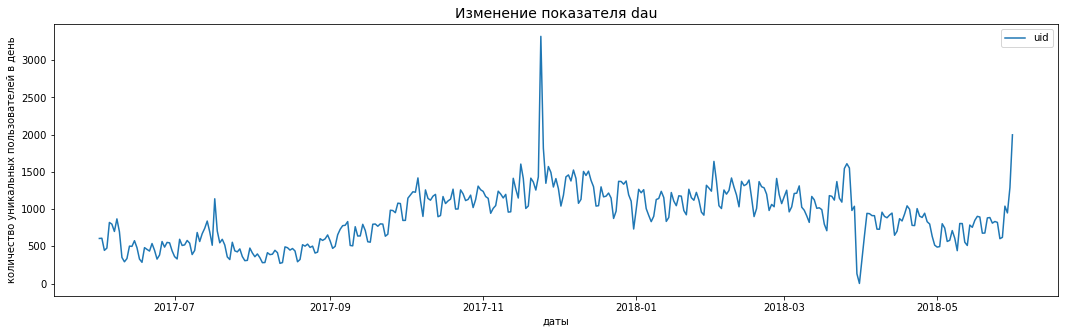

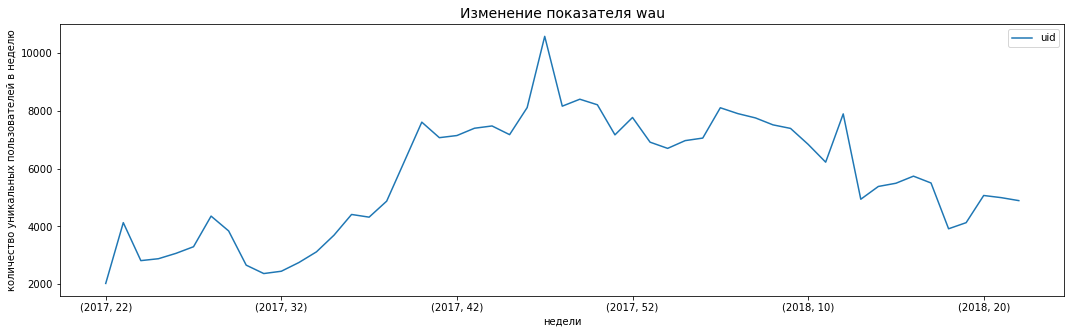

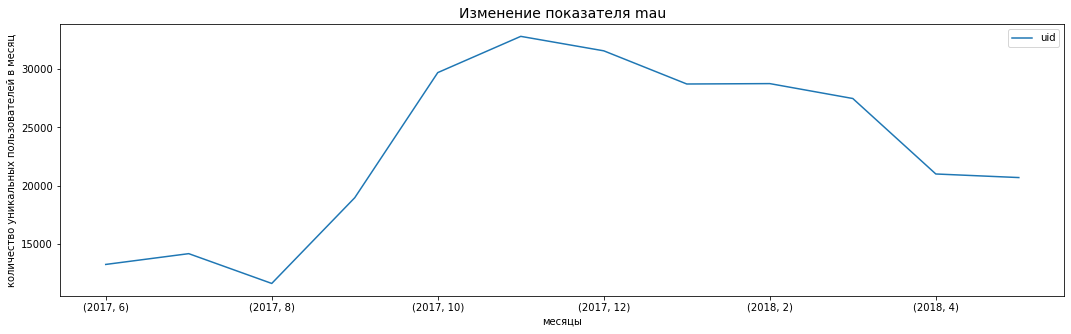

In [25]:
visits.groupby('start_ts_day').agg({'uid':'nunique'}).plot(figsize=(18,5))
plt.title('Изменение показателя dau', fontsize = 14)
plt.ylabel('количество уникальных пользователей в день')
plt.xlabel('даты')

visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid':'nunique'}).plot(figsize=(18,5))
plt.title('Изменение показателя wau', fontsize = 14)
plt.ylabel('количество уникальных пользователей в неделю')
plt.xlabel('недели')

visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid':'nunique'}).plot(figsize=(18,5))
plt.title('Изменение показателя mau', fontsize = 14)
plt.ylabel('количество уникальных пользователей в месяц')
plt.xlabel('месяцы');

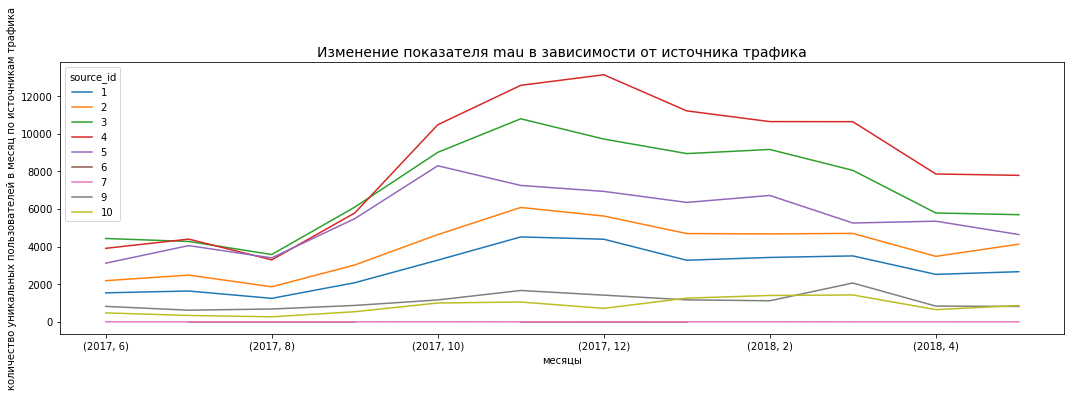

In [26]:
visits.pivot_table(index=['start_ts_year','start_ts_month'], columns = 'source_id', values='uid',aggfunc='count').plot(figsize=(18,5))
plt.title('Изменение показателя mau в зависимости от источника трафика', fontsize = 14)
plt.ylabel('количество уникальных пользователей в месяц по источникам трафика')
plt.xlabel('месяцы');

Text(0.5, 0, 'месяцы')

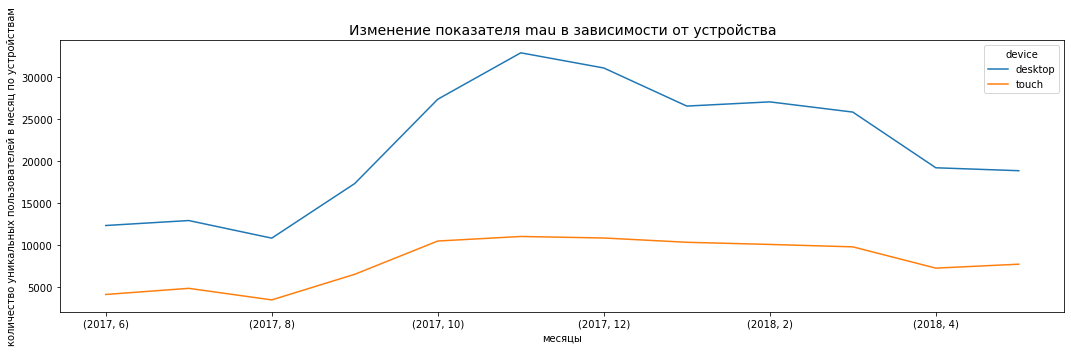

In [27]:
visits.pivot_table(index=['start_ts_year', 'start_ts_month'], columns = 'device', values='uid',aggfunc='count').plot(figsize=(18,5))
plt.title('Изменение показателя mau в зависимости от устройства', fontsize = 14)
plt.ylabel('количество уникальных пользователей в месяц по устройствам')
plt.xlabel('месяцы')

В ноябре и декабре на сайт было привлечено пиковое количество уникальных пользователей. Вероятно, это связано с рекламной кампаний, что должно подтвердиться данными по росту расходов на рекламу в этот период.

Наибольшее количество уникальных пользователей в месяц было привлечено на сервис с источников 4, 3, 5 через устройства desktop.


### 2.1.2. Количество сессий в день<a name="2-1-2"></a>

In [28]:
day_visits = visits.groupby(['start_ts_day']).agg({'uid':'count'})

In [29]:
print('Среднее количество сессий в день - {}'.format(int(day_visits.mean()[0])))  

Среднее количество сессий в день - 987


### 2.1.3. Длительность одной сессии <a name="2-1-3"></a>

In [30]:
visits['duration_ts'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print ('asl, средняя продолжительность сессии - {} секунды'.format(int(visits['duration_ts'].mean())))  

asl, средняя продолжительность сессии - 643 секунды


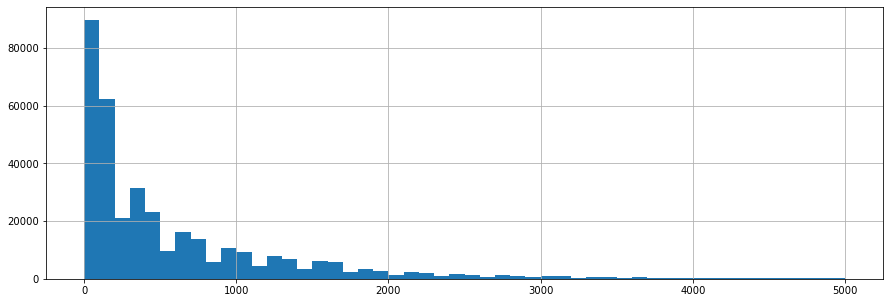

In [31]:
visits['duration_ts'].hist(bins=50, figsize = (15,5), range = (0, 5000)); #проверяем распределение

Распределение продолжительности сессий нельзя отнести к нормальному, поэтому используем в расчёте не среднее, а моду -наиболее часто встречающееся значение:

In [32]:
asl = visits['duration_ts'].mode() #средняя продолжительность сессии или ASL (average session length) 

In [33]:
asl

0    60
dtype: int64

Таким образом, продолжительность одной сессии составляет - 60 секунд.

### 2.1.4. Как часто люди возвращаются? <a name="2-1-4"></a>

Расчитаем Retention Rate, чтобы посмотреть как часто пользователи возвращаются на сайт.

Прежде построим новый объект Series с датой первого посещения сайта:

In [34]:
first_visit = visits.groupby('uid')['start_ts'].min() 
first_visit.name = 'first_visit'

In [35]:
visits = visits.join(first_visit, on = 'uid') #объединяем полученную таблицу с исходной таблицей visits

Определив первую дату контакта с сервисом, строим когорты по месяцам:

In [36]:
#создадим новый датафрейм с нужными столбцами
rr = visits[['uid', 'first_visit', 'start_ts']]
rr['first_activity_month'] = rr['first_visit'].astype('datetime64[M]')
rr['start_ts_month'] = rr['start_ts'].astype('datetime64[M]')
rr['lifetime'] = ((rr['start_ts_month'] - rr['first_activity_month']) / np.timedelta64(1, 'M')).round().astype('int')

cohorts = rr.groupby(['first_activity_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count.columns = ['first_activity_month', 'cohort_users']
initial_users_count = initial_users_count.set_index('first_activity_month')
cohorts = cohorts.join(initial_users_count, on = 'first_activity_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

Считаем Retention Rate:

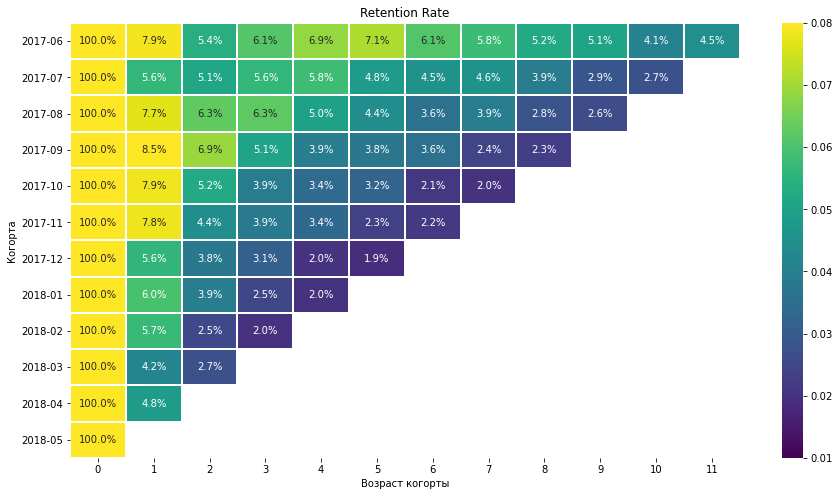

In [37]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='lifetime',values='retention',aggfunc='sum')
retention_pivot = retention_pivot.reset_index()
retention_pivot['first_activity_month'] = retention_pivot['first_activity_month'].dt.strftime('%Y-%m')
retention_pivot = retention_pivot.set_index('first_activity_month')

plt.figure(figsize=(15, 8))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt=".1%", linewidths=1, cmap = 'viridis', vmin=0.01, vmax=0.08)
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show();

Возврат пользователей (Retention Rate)  очень низкий  - 2-7 %. С каждой новой когортой поведение покупателей меняется незначительно. Можно отметить явную сезонность: рост лояльности в период с сентября по март и, соответственно, снижение в тёплое  время года.  
Заметен рост retantion rate в следующем от базового месяце по когорте пользователей, пришедших в январе. Это может объясняться длинными выходными и, соответственно, желанием пользователей провести время в кино, театре или на концерте. Когорта сентября показывает рост во втором месяце, что можно объяснить открытием сезона после летних месяцев. 
Причиной общего низкого уровня вовлечённости может являться отсутствие очевидных примуществ приобретения билетов на платформе Яндекс-Афиша, которая является посредником. Также анализ отзывов показал, что чаще всего пользователи сталкиваются с различными ошибками при оплате и сложными механизмами возврата средств.

#### [Вернуться к оглавлению](#шаг-0)

## 2.2. Продажи <a name="шаг-2-2"></a>

### 2.2.1. Когда люди начинают покупать <a name="2-2-1"></a>

In [38]:
#найдём время и дату первой сессии и ресурс, который при этом использовался:
first_sessions = visits.groupby(['uid']).agg({'start_ts':'min'})
first_sessions.columns = ['first_activity']

In [39]:
#найдём время первой покупки:
first_orders = orders.groupby(['uid']).agg({'buy_ts':'min'})
first_orders.columns = ['first_buy_ts']

#добавим дату и время первой сессии в таблицу по первым заказам:
first_orders = first_orders.merge(first_sessions, on='uid')

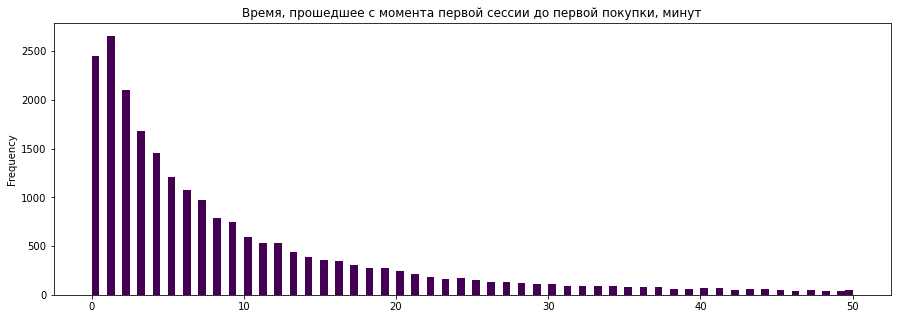

In [40]:
#найдём время, прошедшее с момента первой сессии до первой покупки:
first_orders['time_first_purchase'] = (first_orders['first_buy_ts'] - first_orders['first_activity']) / np.timedelta64(1, 'm')
first_orders['time_first_purchase'].plot(kind = 'hist', bins = 100, range = (0,50), figsize = (15,5), title = 'Время, прошедшее с момента первой сессии до первой покупки, минут', cmap = 'viridis');

Распределение далеко от нормального, поэтому будем использовать значение **моды**:

In [41]:
print('Время с момента первой сессии до первой покупки: {} мин.'.format(int(first_orders['time_first_purchase'].mode())))

Время с момента первой сессии до первой покупки: 1 мин.


Очевидно, что покупатели, которые затрачивают одну минуту на сайте для покупки, пришли на сервис целенаправленно, получив уже всю нужную информацию на других ресурсах.

### 2.2.2. Сколько раз покупают за период <a name="2-2-2"></a>

Определим частоту покупок для разных периодов времени: в день, в неделю, в месяц и в год. 


In [42]:
orders = orders.join(first_orders, on='uid')

In [43]:
day_purchases_per_user = orders.groupby(['buy_ts_day', 'uid']).agg({'buy_ts':'count'}).mean()[0]
week_purchases_per_user = orders.groupby(['buy_ts_year', 'uid']).agg({'buy_ts':'count'}).mean()[0]
month_purchases_per_user = orders.groupby(['buy_ts_month', 'uid']).agg({'buy_ts':'count'}).mean()[0]
year_purchases_per_user = orders.groupby(['buy_ts_year', 'uid']).agg({'buy_ts':'count'}).mean()[0]

In [44]:
print('Частота покупок в день: {:.2f}'.format(day_purchases_per_user.mean()))
print('Частота покупок в неделю: {:.2f}'.format(week_purchases_per_user.mean()))
print('Частота покупок в месяц: {:.2f}'.format(month_purchases_per_user.mean()))
print('Частота покупок в год: {:.2f}'.format(year_purchases_per_user.mean()))

Частота покупок в день: 1.08
Частота покупок в неделю: 1.32
Частота покупок в месяц: 1.23
Частота покупок в год: 1.32


Частота покупок для разных периодов говорит, что покупки совершаются в основном однократно. Это кажется логичным после расчёта retantion rate.

### 2.2.3. Средний чек <a name="2-2-3"></a>

In [45]:
orders['first_buy_month'] = orders['first_buy_ts'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [46]:
average_order_value = ((orders['revenue'].mean()))
print('Средний чек равен {:.2f} руб.'.format(average_order_value))

Средний чек равен 5.00 руб.


In [47]:
orders_cohorts = (orders.groupby(['first_buy_month', 'buy_month']).agg({'revenue':'sum', 'uid':'count'})).reset_index()

In [48]:
orders_cohorts['average_revenue'] = orders_cohorts['revenue'] / orders_cohorts['uid']

In [49]:
orders_cohorts['lifetime'] = ((orders_cohorts['buy_month'] -orders_cohorts['first_buy_month'])/np.timedelta64(1, 'M')).round().astype('int')
orders_cohorts['first_buy_month'] = orders_cohorts['first_buy_month'].dt.strftime('%Y-%m')

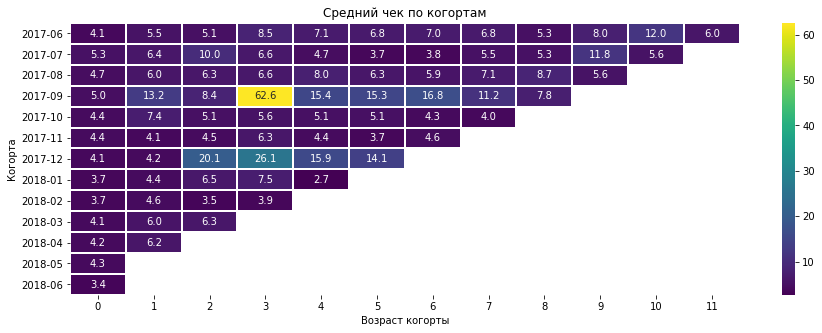

In [50]:
# Стоим тепловую карту 
average_revenue_pivot = (orders_cohorts.pivot_table(index='first_buy_month', columns='lifetime',values='average_revenue', aggfunc='mean'))
plt.figure(figsize=(15, 5))
plt.title('Средний чек по когортам')
sns.heatmap(average_revenue_pivot, annot=True, fmt='.1f', linewidths=1,  cmap = 'viridis')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show();

Тепловая карта показывает, что когорты сентября и декабря активно тратили деньги в суммах выше среднего чека. 

### 2.2.4. Сколько денег приносят (LTV) <a name="2-2-4"></a> 

In [51]:
#выделим месяцы из дат в таблицах с заказами и расходами:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]') 

#получим месяц первой покупки каждого покупателя:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

#посчитаем количество новых покупателей (n_buyers) за каждый месяц:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

#построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:
orders_new = pd.merge(orders,first_orders, on='uid')

#cгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 
#cбросим индекс методом reset_index():
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

#добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

#далее нужно найти валовую прибыль, умножив выручку на маржинальность. Здесь примем допущение, что маржинальность  равна 100%.
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

#теперь найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. 
#для наглядности визуализируем когорты в виде сводной таблицы:
report['ltv'] = report['gp'] / report['n_buyers']
output = report.pivot_table(index='first_order_month',columns='age', values='ltv', aggfunc='mean')
output.fillna('') 

#посчитаем итоговый LTV первой когорты. Сложим их LTV по месяцам:
ltv_201706 = output.loc['2017-06-01'].sum()

In [52]:
ltv_201706

11.879233811171527

В среднем каждый покупатель из первой когорты принес по 11,9 рублей выручки за 12 месяцев.

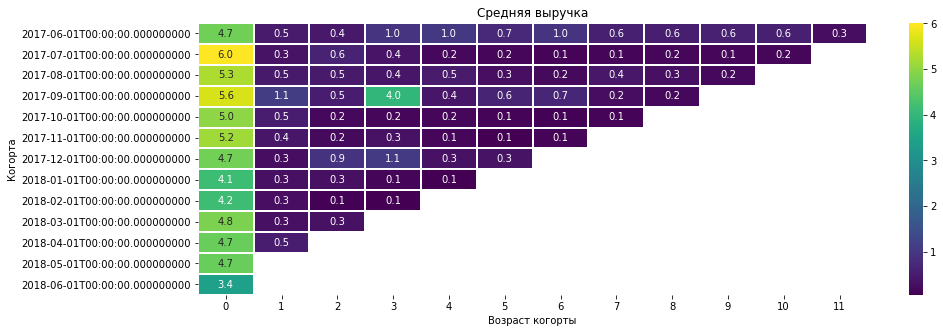

In [53]:
#построим тепловую карту для оценки средней выручки:
    
plt.figure(figsize=(15, 5))
plt.title('Средняя выручка')
sns.heatmap(output, annot=True, fmt=".1f", linewidths=1, cmap = 'viridis')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

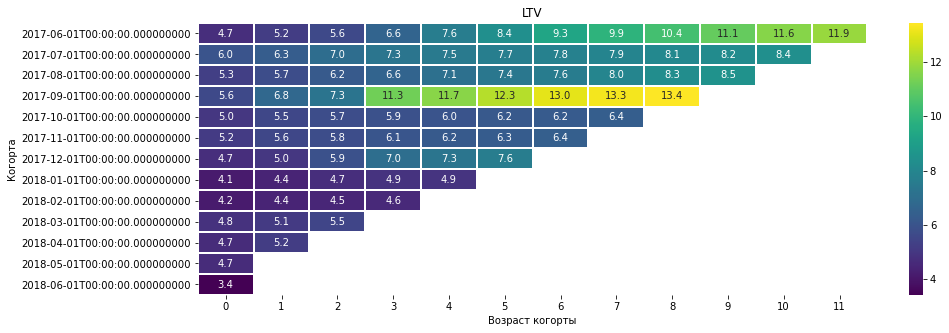

In [54]:
#собственно показатели LTV. Кумулятивный эффект на диаграмме позволяет оценить динамику:
ltv = output.cumsum(axis = 1)
plt.figure(figsize=(15, 5))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt=".1f", linewidths=1, cmap = 'viridis')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

## Выводы

- Время с момента первой сессии до первой покупки: 1 мин. Очевидно, что покупатели, которые затрачивают одну минуту на сайте для покупки, пришли на сервис целенаправленно, получив уже всю нужную информацию на других ресурсах.
- Частота покупок для разных периодов говорит, что покупки совершаются в основном однократно. Это кажется логичным после расчёта retantion rate:
    - Частота покупок в день: 1.08
    - Частота покупок в неделю: 1.32
    - Частота покупок в месяц: 1.23
    - Частота покупок в год: 1.32

- Тепловая карта показывает, что когорты сентября и декабря активно тратили деньги в суммах выше среднего чека. 
- Когорты сентября и июня демонстрируют рост показателя  ценности клиента ltv.


#### [Вернуться к оглавлению](#шаг-0)

## 2.3. Маркетинг <a name="шаг-2-3"></a>

### 2.3.1. Сколько денег потратили (всего / на каждый источник / по времени) <a name="2-3-1"></a>

In [55]:
total_costs = costs['costs'].sum()
total_costs

329131.62

In [56]:
#Суммы затрат на каждый источник
costs_source = costs.groupby(['source_id']).agg({'costs': 'sum'}).sort_values(by='costs', ascending=False).reset_index()
costs_source['cost_percentage']=(costs_source['costs']/(costs_source['costs'].sum()))*100
costs_source.sort_values(by='source_id')

,source_id,costs,cost_percentage
4,1,20833.27,6.329769
3,2,42806.04,13.005751
0,3,141321.63,42.937725
1,4,61073.60,18.555981
2,5,51757.10,15.725350
6,9,5517.49,1.676378
5,10,5822.49,1.769046


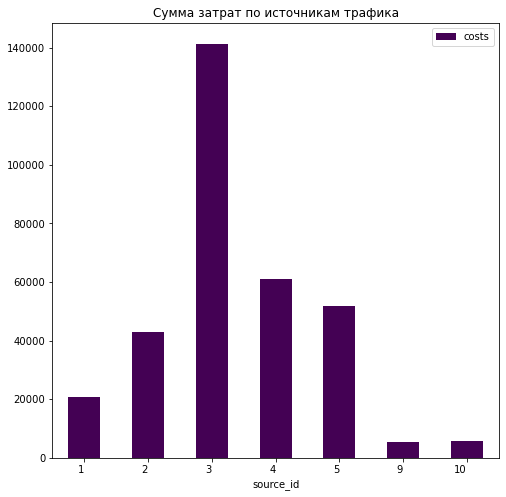

In [57]:
(costs_source.groupby('source_id')['costs'].agg('sum').plot(kind='bar', legend=True, figsize=(8, 8),cmap = 'viridis', title='Сумма затрат по источникам трафика'))
plt.xticks(rotation=0, ha='right')
#plt.xticks(rotation='vertical')

# ax = sns.countplot(x="source_id", data=costs_source)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# plt.tight_layout()
# plt.show()

plt.show()


Общая сумма маркетинговых затрат составила - 329131.62 руб.
Основная доля затрат пришлась на источники 3 (42,9%), 4 (18,6%), 5 (15,7%). Минимальные затраты на источники 1, 10 и 9 (общая доля по ним не превысила 10%).

In [58]:
#приведём суммы затрат на каждый источник по месяцам:
costs_by_month = costs.groupby(['source_id', 'month']).agg({'costs': 'sum'}).reset_index()

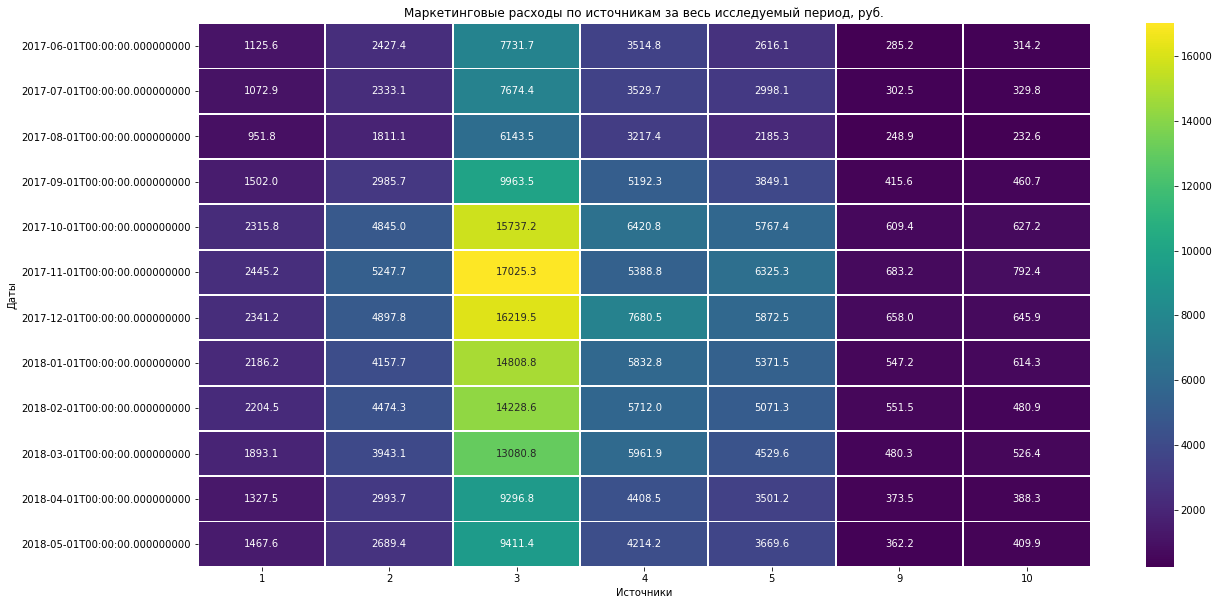

In [59]:
#создадим сводную таблицу с затратами по типу источника
costs_pivot = costs_by_month.pivot_table(index='month',  columns='source_id', values='costs', aggfunc='sum')
plt.figure(figsize=(20, 10))
plt.title('Маркетинговые расходы по источникам за весь исследуемый период, руб.')
sns.heatmap(costs_pivot, annot=True, fmt=".1f", linewidths=1, cmap = 'viridis')
plt.xlabel('Источники')
plt.ylabel('Даты')
plt.show()

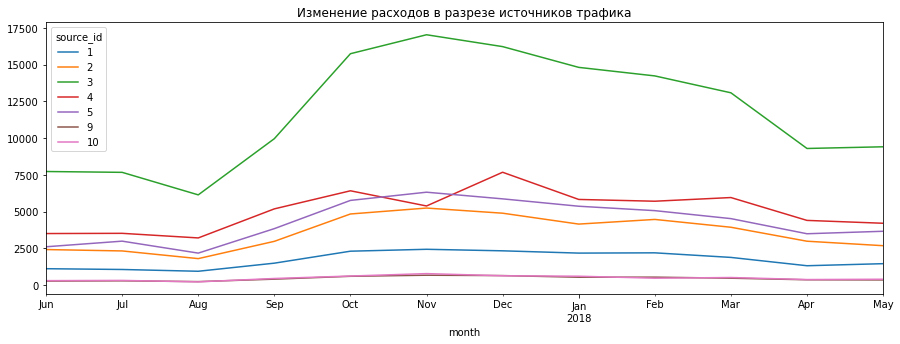

In [60]:
costs_pivot.plot(figsize=(15,5), title='Изменение расходов в разрезе источников трафика');

### 2.3.2. Стоимость привлечения одного покупателя из каждого источника <a name="2-3-2"></a>

In [61]:
#определяем суммарные затраты по источникам при помощи группировки:
costs_source = costs.groupby(['dt', 'source_id'])['costs'].sum().reset_index()
costs_source['day'] = costs_source['dt'].astype('datetime64[D]') 
costs_source

,dt,source_id,costs,day
0,2017-06-01,1,75.20,2017-06-01
1,2017-06-01,2,132.56,2017-06-01
2,2017-06-01,3,349.38,2017-06-01
3,2017-06-01,4,76.74,2017-06-01
4,2017-06-01,5,73.24,2017-06-01
...,...,...,...,...
2537,2018-05-31,3,822.30,2018-05-31
2538,2018-05-31,4,492.54,2018-05-31
2539,2018-05-31,5,398.04,2018-05-31
2540,2018-05-31,9,27.37,2018-05-31


In [62]:
costs_source['costs'].sum()

329131.62

In [63]:
#считаем  пользоватлей по первой активности, чтобы определить источник  
frst_ts = visits.groupby(['uid', 'device']).agg({'source_id': 'first'}).reset_index()
frst_ts.head(1)

,uid,device,source_id
0,11863502262781,touch,3


In [64]:
#мержим
frst_ordr=orders.groupby(['uid']).agg({'buy_ts': 'min', 'revenue': 'sum'}).reset_index().merge(frst_ts, on =['uid'])
frst_ordr['day'] = frst_ordr['buy_ts'].astype('datetime64[D]') 
frst_ordr = frst_ordr.rename(columns = {'buy_ts': 'first_buy'})
frst_ordr

,uid,first_buy,revenue,device,source_id,day
0,313578113262317,2018-01-03 21:51:00,0.55,desktop,2,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,3.05,touch,10,2017-06-03
2,2429014661409475,2017-10-11 18:33:00,73.33,desktop,3,2017-10-11
3,2464366381792757,2018-01-28 15:54:00,2.44,desktop,5,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,10.99,desktop,5,2017-11-24
...,...,...,...,...,...,...
39509,18445407535914413204,2017-09-22 23:55:00,0.88,touch,3,2017-09-22
39510,18445601152732270159,2018-03-26 22:54:00,4.22,desktop,2,2018-03-26
39511,18446156210226471712,2018-02-18 19:34:00,9.78,desktop,3,2018-02-18
39512,18446156210226471712,2018-02-18 19:34:00,9.78,touch,1,2018-02-18


In [65]:
frst_ordr['uid'].nunique()

36523

In [66]:
#и считаем их количество в разрезе источников
frst_ordr_source=frst_ordr.groupby(['source_id', 'day', 'device']).agg({'uid': 'nunique'}).reset_index()
frst_ordr_source

,source_id,day,device,uid
0,1,2017-06-01,desktop,12
1,1,2017-06-01,touch,2
2,1,2017-06-02,desktop,6
3,1,2017-06-03,desktop,6
4,1,2017-06-03,touch,2
...,...,...,...,...
4531,10,2018-05-29,touch,1
4532,10,2018-05-30,desktop,2
4533,10,2018-05-30,touch,3
4534,10,2018-05-31,desktop,30


In [67]:
cac_month=frst_ordr_source.merge(costs_source, on=['source_id', 'day'])
cac_month['month'] = cac_month['day'].astype('datetime64[M]') 
cac_month=cac_month.groupby(['device', 'source_id', 'month']).agg({'uid': 'sum' , 'costs':'sum'}).reset_index()
cac_month

,device,source_id,month,uid,costs
0,desktop,1,2017-06-01,175,1053.89
1,desktop,1,2017-07-01,181,1059.57
2,desktop,1,2017-08-01,117,951.81
3,desktop,1,2017-09-01,228,1502.01
4,desktop,1,2017-10-01,340,2315.75
...,...,...,...,...,...
163,touch,10,2018-01-01,22,253.49
164,touch,10,2018-02-01,22,297.85
165,touch,10,2018-03-01,46,408.91
166,touch,10,2018-04-01,26,189.26


In [68]:
cac_month['costs'].sum() 

643509.69

In [69]:
cac_month['cac'] = cac_month['costs']/cac_month['uid']
cac_month

,device,source_id,month,uid,costs,cac
0,desktop,1,2017-06-01,175,1053.89,6.022229
1,desktop,1,2017-07-01,181,1059.57,5.853978
2,desktop,1,2017-08-01,117,951.81,8.135128
3,desktop,1,2017-09-01,228,1502.01,6.587763
4,desktop,1,2017-10-01,340,2315.75,6.811029
...,...,...,...,...,...,...
163,touch,10,2018-01-01,22,253.49,11.522273
164,touch,10,2018-02-01,22,297.85,13.538636
165,touch,10,2018-03-01,46,408.91,8.889348
166,touch,10,2018-04-01,26,189.26,7.279231


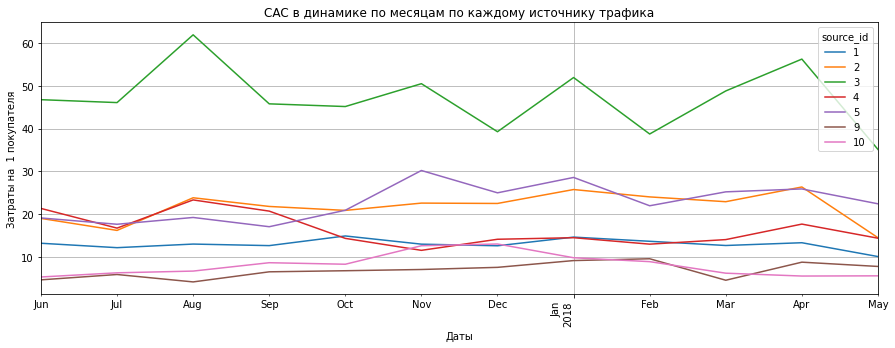

In [70]:
cac_month.pivot_table(index = ['month'], columns='source_id', values='cac', aggfunc='mean').plot(figsize=(15,5), grid=True)
plt.title('CAC в динамике по месяцам по каждому источнику трафика')
plt.ylabel('Затраты на  1 покупателя')
plt.xlabel('Даты')
plt.xticks(rotation=90, ha='right'); 

Отразим CAC для каждого источника итого: 

In [71]:
cac_total = cac_month.groupby(['source_id']).agg({'uid': 'sum', 'costs': 'sum'}).reset_index()
cac_total['cac'] = cac_total['costs']/cac_total['uid']
cac_total


,source_id,uid,costs,cac
0,1,3994,39510.27,9.892406
1,2,4810,83691.28,17.399435
2,3,9943,280206.96,28.181330
3,4,10618,122091.59,11.498549
4,5,7241,101232.38,13.980442
5,9,1582,8489.23,5.366138
6,10,1324,8287.98,6.259804


In [72]:
cac_total['uid'].sum()

39512

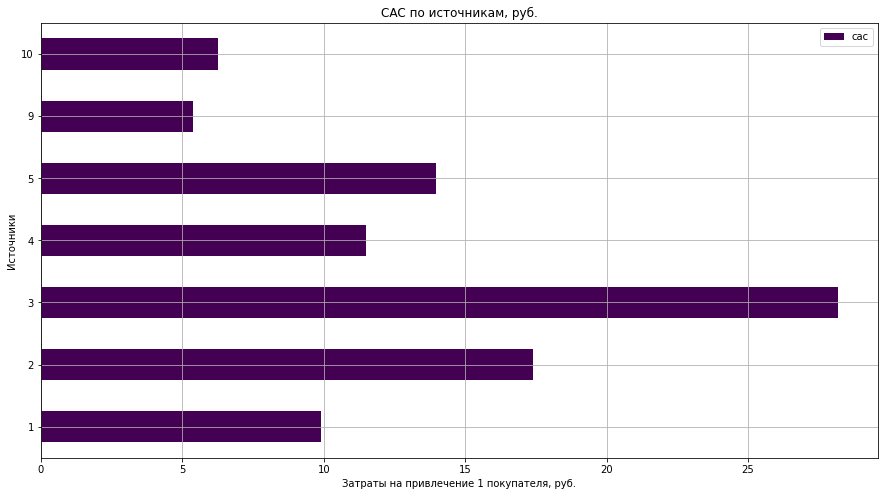

In [73]:
cac_total.plot(kind ='barh', x='source_id', y='cac', figsize=(15,8), grid=True, cmap='viridis')
plt.title('CAC по источникам, руб.')
plt.xlabel('Затраты на привлечение 1 покупателя, руб.')
plt.ylabel('Источники')
plt.show();

У источника трафика (номер 3), в который компания инвестировала больше всего, были самые высокие затраты на привлечение одного клиента. Наименьший объём затрат на привлечение одного покупателя приходится на источник номер 9. 
Отдельного внимания заслуживает источник 4, стоимость привлечения одного покупателя через который почти в два раза ниже, чем у ресурса 3, но количество привлечённых покупателей практически одинаково, также для 4 источника доля общих  маркетинговых затрат при этом в 2,3 раза ниже, чем для 3 источника.

### 2.3.3. Окупаемость расходов (ROI) <a name="2-3-3"></a>

Поскольку речь идёт маркетнговых затратах расчитаем ROMI. Расчитаем ROMI по формуле:

   **ROMI = LTV/CAC**
    
Рассмотрим окупаемость по каждому из источников трафика.

In [74]:

# считаем ltv
ltv = frst_ordr.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)
orders_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue_y', aggfunc = 'count').fillna(0)
buyers_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'uid', aggfunc = 'nunique').fillna(0)
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue_y', aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)

# добавляем размеры когорт 
cohort_sizes = frst_ordr.groupby('source_id').agg({'uid': 'nunique'})
ltv = ltv.merge(cohort_sizes, on = 'source_id')


# считаем САС
cac_total = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id')
cac_total['cac'] = cac_total['costs'] / cac_total['uid']
cac_total = cac_total.set_index('source_id')

# считаем ROMI
romi = ltv.merge(cac_total[['costs']], on = 'source_id')
romi = romi.div(romi['costs'], axis = 0).drop(columns = 'costs')


In [75]:
cac_total

,costs,uid,cac
source_id,,,
1,20833.27,3958,5.263585
2,42806.04,4674,9.158331
3,141321.63,9701,14.567738
4,61073.60,10340,5.906538
5,51757.10,7140,7.248894
9,5517.49,1539,3.585114
10,5822.49,1305,4.461678


In [76]:
ltv

,0,1,2,3,4,5,6,7,8,9,10,11,12,uid
source_id,,,,,,,,,,,,,,
1,25488.43,29812.81,33371.68,35336.42,37296.88,38947.02,40419.33,41432.73,42317.97,43288.75,43967.38,44225.50,44282.02,3958
2,32519.49,38482.86,46133.77,60811.90,65298.74,68583.25,70130.46,71308.25,72612.12,73176.23,73606.16,73907.71,74139.60,4674
3,44110.23,46237.86,47523.78,48824.74,49624.72,50092.13,50630.22,51108.27,51288.34,51508.32,51668.11,51719.65,51724.41,9701
4,50362.93,52503.32,53889.04,55463.32,56651.55,58108.58,58509.47,59149.48,59518.74,59732.71,60014.01,60053.05,60069.31,10340
5,34650.34,36295.25,37798.24,39135.10,40037.21,40718.14,41401.06,41847.40,42250.37,42574.13,42643.34,42729.41,42743.63,7140
7,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1
9,6157.16,6632.46,6946.49,7199.93,7397.15,7475.09,7627.69,7672.43,7917.96,8041.56,8053.84,8053.84,8053.84,1539
10,4169.43,4265.09,4315.44,4377.99,4399.04,4414.58,4435.03,4454.23,4464.99,4464.99,4464.99,4464.99,4469.64,1305


In [77]:
cac_total

,costs,uid,cac
source_id,,,
1,20833.27,3958,5.263585
2,42806.04,4674,9.158331
3,141321.63,9701,14.567738
4,61073.60,10340,5.906538
5,51757.10,7140,7.248894
9,5517.49,1539,3.585114
10,5822.49,1305,4.461678


In [78]:
romi

,0,1,2,3,4,5,6,7,8,9,10,11,12,uid
source_id,,,,,,,,,,,,,,
1,1.223448,1.431019,1.601846,1.696153,1.790256,1.869463,1.940134,1.988777,2.031269,2.077866,2.110441,2.122830,2.125543,0.189985
2,0.759694,0.899005,1.077740,1.420638,1.525456,1.602186,1.638331,1.665846,1.696305,1.709484,1.719527,1.726572,1.731989,0.109190
3,0.312127,0.327182,0.336281,0.345487,0.351147,0.354455,0.358262,0.361645,0.362919,0.364476,0.365607,0.365971,0.366005,0.068645
4,0.824627,0.859673,0.882362,0.908139,0.927595,0.951452,0.958016,0.968495,0.974541,0.978045,0.982651,0.983290,0.983556,0.169304
5,0.669480,0.701261,0.730301,0.756130,0.773560,0.786716,0.799911,0.808534,0.816320,0.822576,0.823913,0.825576,0.825851,0.137952
9,1.115935,1.202079,1.258995,1.304929,1.340673,1.354799,1.382457,1.390565,1.435066,1.457467,1.459693,1.459693,1.459693,0.278931
10,0.716091,0.732520,0.741167,0.751910,0.755526,0.758195,0.761707,0.765004,0.766852,0.766852,0.766852,0.766852,0.767651,0.224131


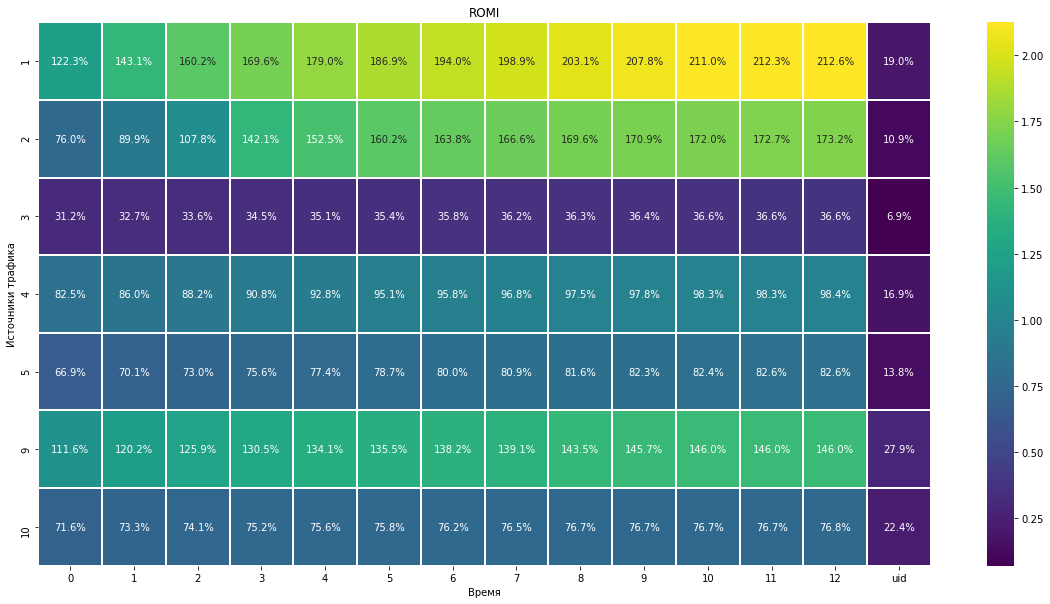

In [79]:
#посмотрим на тепловую карту изменения ROMI с течением времени:
plt.figure(figsize=(20, 10))
plt.title('ROMI')
sns.heatmap(romi, annot=True, fmt=".1%", linewidths=1, cmap = 'viridis')
plt.xlabel('Время')
plt.ylabel('Источники трафика')
plt.show()

### 2.3.4. Изменение CAC в зависимости от устройства, источника и во времени <a name="2-3-4"></a>


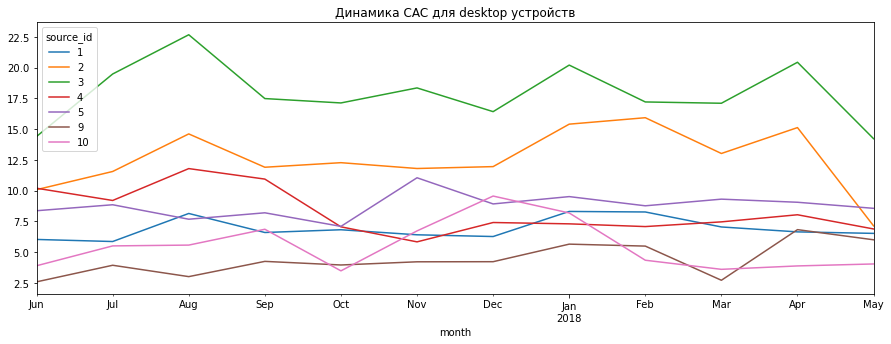

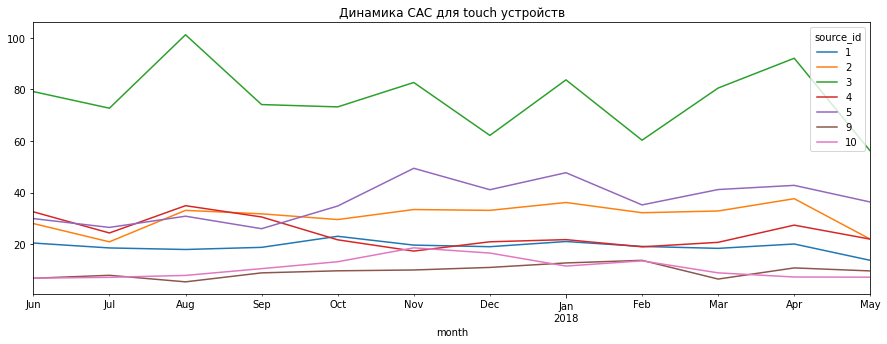

In [80]:
cac_month.query('device == "desktop"').pivot_table(index = 'month', columns = 'source_id', values = 'cac', aggfunc = 'mean')\
.plot(figsize=(15, 5))
plt.title('Динамика CAC для desktop устройств')


cac_month.query('device == "touch"').pivot_table(index = 'month', columns = 'source_id', values = 'cac', aggfunc = 'mean')\
.plot(figsize=(15, 5))
plt.title('Динамика CAC для touch устройств');

#### [Вернуться к оглавлению](#шаг-0)

## Выводы

-  Общая сумма маркетинговых затрат  составила - 329131.62 руб.
Основная доля затрат пришлась на источники 3 (42,9%), 4 (18,6%), 5 (15,7%). Минимальные затраты на источники 1, 10 и 9 (общая доля по ним не превысила 10%).

- У источника трафика (номер 3), в который компания инвестировала больше всего, были самые высокие затраты на привлечение одного клиента. Наименьший объём затрат на привлечение одного покупателя приходится на источник номер 1. 
Отдельного внимания заслуживает источник 4, стоимость привлечения одного покупателя через который в два раза ниже, чем у ресурса 3, но количество привлечённых покупателей практически одинаково, также для 4 источника доля общих  маркетинговых затрат при этом в 2,3 раза ниже, чем для 3 источника.

- Показатель ROMI с течением времени показал рост для 1, 2, 9 источников трафика. Именно эти источники выглядят наиболее привлекательным для маркетинговых инвестиций,  поскольку на них  был потрачено в совокупности  не более 22% бюджета  при высоком темпе роста ROMI. Медленный рост ROMI характерен для  большинства групп по источникам трафика, но только три источника позволяют осуществить возврат маркетинговых инвестиций: 1, 2 и 9. 

- Стоимость привлечения одного клиента для touch устройств значительно выше, чем для desktop, особенно для источников 3, 5, 2. Вероятно, большая аудитории не пользуется ресурсом Афиши через мобильные устройства. 


# Шаг 3. Общие выводы и рекомендации  <a name="шаг-3"></a>




## Выводы:

- В ноябре и декабре на сайт было привлечено пиковое количество уникальных пользователей. Вероятно, это связано с рекламной кампанией, что подтверждается данными по росту расходов на рекламу в этот период.

- Наибольшее количество уникальных пользователей в месяц было привлечено на сервис с источников 4, 3, 5 через устройства desktop.

- Наиболее высокий ltv у первой когорты (июнь 2017) и четвертой когорты (сентябрь 2017). Отметим, что в сентябре произошел значительный скачок показателя благодаря одному только месяцу (возраст 3)  и затем показатель рос не столь  значительно.  Другая ситуация по первой когорте: здесь показатель ценности клиента  демонстрирует плавный рост на протяжении всей жизни когорты.  Относительно неплохо складывается ситуация с показателем ltv у когорты декабря 2017. 

- Средний чек равен 5.00 руб.

- Очевидно, что покупатели, которые затрачивают одну минуту на сайте для покупки, пришли на сервис целенаправленно, получив уже всю нужную информацию на других ресурсах.

- Возврат пользователей (Retention Rate) очень низкий - 2-7 %. С каждой новой когортой поведение покупателей меняется незначительно. Можно отметить явную сезонность: рост лояльности в период с сентября по март и, соответственно, снижение в тёплое время года.

- Заметен рост retantion rate в следующем от базового месяца по когорте пользователей, пришедших в январе. Это может объясняться длинными выходными и, соответственно, желанием пользователей провести время в кино, театре или на концерте. Когорта сентября показывает рост во втором месяце, что можно объяснить открытием сезона после летних месяцев. Причиной общего низкого уровня вовлечённости может являться отсутствие очевидных преимуществ приобретения билетов на платформе Яндекс-Афиша, которая является посредником. Также анализ отзывов показал, что чаще всего пользователи сталкиваются с различными ошибками при оплате и сложными механизмами возврата средств.

- Время с момента первой сессии до первой покупки: 1 мин. Очевидно, что покупатели, которые затрачивают одну минуту на сайте для покупки, пришли на сервис целенаправленно, получив уже всю нужную информацию на других ресурсах.

- Частота покупок для разных периодов говорит, что покупки совершаются в основном однократно. Это кажется логичным после расчёта retantion rate, этот показатель, отражающий вовлечённость, довольно низкий.

- Тепловая карта показывает, что когорты сентября и декабря активно тратили деньги в суммах выше среднего чека. 

- Когорты сентября и июня демонстрируют рост показателя  ценности клиента ltv.

-  Общая сумма маркетинговых затрат составила - 329131.62 руб.
Основная доля затрат пришлась на источники 3 (42,9%), 4 (18,6%), 5 (15,7%). Минимальные затраты на источники 1, 10 и 9 (общая доля по ним не превысила 10%).

-  У источника трафика (номер 3), в который компания инвестировала больше всего, были самые высокие затраты на привлечение одного клиента. Наименьший объём затрат на привлечение одного покупателя приходится на источник номер 1. 
Отдельного внимания заслуживает источник 4, стоимость привлечения одного покупателя через который в два раза ниже, чем у ресурса 3, но количество привлечённых покупателей практически одинаково, также для 4 источника доля общих  маркетинговых затрат при этом в 2,3 раза ниже, чем для 3 источника.


- Медленный рост ROMI характерен для  большинства групп по источникам трафика, но только три источника позволяют осуществить возврат маркетинговых инвестиций:показатель ROMI с течением времени показал рост для 1, 2  и 9 источников  трафика. Именно эти  источники выглядят наиболее привлекательными для маркетинговых инвестиций,  поскольку на них был потрачено только 6,3% , 12%  и 3,5% бюджета соответственно  при высоком темпе роста ROMI. 

- Стоимость привлечения одного клиента для touch устройств значительно выше, чем для desktop, особенно для источников 3, 5, 2. Вероятно, большая аудитории не пользуется ресурсом Афиши через мобильные устройства. 



## Рекомендации:

Для составления рекомендаций по распределению инвестиций среди семи основных источников трафика на сайт необходимо учитывать в совокупности все показатели, которые были расчитаны в рамках данного исследования.

На источник 3 затрачивается более 49 процентов бюджета, здесь инвестиции не окупаются. Этот ресурс, безусловно, привлекает большое число пользователей, но эффективность этой работы отсутствует (romi = 31%). Именно поэтому необходимо проанализировать весь путь клиента с момента входа на сайт, чтобы ответить на вопросы: как увеличить лояльность пользователей, что мешает осуществить покупку, почему пользователь не вернулся, как увеличить средний чек. 
 
Отдельного внимания заслуживает источник 4, стоимость привлечения одного покупателя через который в два раза ниже, чем у ресурса 3, но количество привлечённых покупателей практически одинаково, также для 4 источника доля общих  маркетинговых затрат при этом в 2,3 раза ниже, чем для 3 источника. Но рентабельность инвестиций для источника 4 составляет только 85%, несмотря постоянный рост этого показателя. Поэтому необходимо оценить, что повлияло на рост рентабельности с течением времени и усилить эти факторы.  
 
Следует увеличить инвестиции в 1 источник, именно он показывает наибольший темп роста показателя рентабельности инвестиций с течением времени. Стоимость привлечения одного клиента для этого источника самая низкая - 5.5 руб. 


Работа сервиса подвержена сезонности: спад активности летом и рост активности в осенне-зимний период. Предлагается возможность рассмотреть включение в продуктовый портфель других услуг, например, лектории или мастер-классы по прикладному искусству. 

Необходимо увеличить вовлечённость/лояльность клиентов, что найдёт своё отражение в показателе sticky factor. Большинство пользуется сервисом однократно (низкий Retention Rate), следует выяснить почему это происходит. Маркетинговый опрос позволит найти ответы на вопросы.

Клиенты не пользуется ресурсом Афиши через мобильные устройства именно поэтому  






#### [Вернуться к оглавлению](#шаг-0)